In [1]:
%matplotlib notebook    
# % indicates magic funciton -> runs command. Run %magic in a cell for more info

### Sync latest file from server

In [64]:
import subprocess

SSH_PATH='ethanblagg@10.0.0.9:~/Documents/scripts/'
SSH_IDENTITY_FILE='~/.ssh/id_rsa_ubuntu_server'
LOCAL_PATH='/Users/ethanblagg/Nextcloud/Documents/Projects/Chia/data/'
F_LOG='netspace-size.log'


try:
    print(subprocess.check_output(['scp', '-i', SSH_IDENTITY_FILE,
                                   SSH_PATH + F_LOG,
                                   LOCAL_PATH
                                  ]))
        
except subprocess.CalledProcessError as err:
    print(err)


b''


### Get data from CSV

In [65]:
import numpy as np
import csv
import datetime, matplotlib

file_name = LOCAL_PATH + F_LOG

epoch_time_arr = []
chia_farmed_arr = []
num_plots_arr = []
plots_size_PiB_arr = []
net_size_PiB_arr = []
win_prob_arr = []
headers = []

with open(file_name, newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',', quotechar='|')
    
    headers = next(data)
    
    for i, row in enumerate(data):
        #print(i)
        epoch_time_arr.append(float(row[0]))
        chia_farmed_arr.append(float(row[1]))
        num_plots_arr.append(float(row[2]))
        plots_size_PiB_arr.append(float(row[3]))
        net_size_PiB_arr.append(float(row[4]))
        win_prob_arr.append(float(row[5]))

        
epoch_times    = np.array(epoch_time_arr)
chia_farmed    = np.array(chia_farmed_arr)
num_plots      = np.array(num_plots_arr)
plots_size_PiB = np.array(plots_size_PiB_arr)
net_size_PiB   = np.array(net_size_PiB_arr)
win_prob       = np.array(win_prob_arr)


# create date-time (number) array for plotting
tts = np.copy(epoch_times)                         # seconds since epoch
ttd = np.copy(epoch_times)                         # days since epoch

tts_zeroed = np.copy(tts) - tts[0]

for i, t in enumerate(ttd):
    ttd[i] = matplotlib.dates.epoch2num(ttd[i])

ttd_zeroed = np.copy(ttd) - ttd[0]

first_sample_index = 219

# Deprecated....
xx = np.copy(epoch_times)


print("epoch_time_arr[-1]: {}".format(epoch_time_arr[-1]))
print("tts[0]: {} \t\t tts[-1]: {}".format(tts[0], tts[-1]))
print("ttd[0]: {} \t ttd[-1]: {}".format(ttd[0], ttd[-1]))
print("ttdz[0]: {} \t\t\t ttdz[-1]: {}".format(ttd_zeroed[0], ttd_zeroed[-1]))
print("ttsz[0]: {} \t\t\t ttsz[-1]: {}".format(tts_zeroed[0], tts_zeroed[-1]))
    

epoch_time_arr[-1]: 1624070101.0
tts[0]: 1616180984.0 		 tts[-1]: 1624070101.0
ttd[0]: 737868.7984259259 	 ttd[-1]: 737960.107650463
ttdz[0]: 0.0 			 ttdz[-1]: 91.3092245371081
ttsz[0]: 0.0 			 ttsz[-1]: 7889117.0


### Netspace size prediction

##### Data for when updates are released

In [66]:
updates = [
    [np.datetime64('2021-04-14T13:00'), '1.0.5'],
    [np.datetime64('2021-04-21T13:00'), '1.1.0'],
    [np.datetime64('2021-04-22T13:00'), '1.1.1'],
    [np.datetime64('2021-04-25T13:00'), '1.1.2'],
    [np.datetime64('2021-05-01T13:00'), '1.1.3'],
    [np.datetime64('2021-05-04T12:00'), '1.1.4'],
    [np.datetime64('2021-05-09T13:00'), '1.1.5'],
    [np.datetime64('2021-05-20T18:30'), '1.1.6'],
    [np.datetime64('2021-06-05T18:30'), '1.1.7']
          ]


##### Plot

In [67]:

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import time

PLOT_EXP = False
PLOT_SIG = True
PLOT_UPDATES = True

prediction_interval = 50

sigmoid_offset = int(net_size_PiB[0]) # correction for y offset for sigmoid (doesn't want to work in func_sigmoid)

# Curve fitting functions
def func_exp(x, a, b, c):
    return (a * (x**b)) + c

def func_sigmoid(x, a, b, c, d):
    return (d / (a + b*math.e**(-c*x))) + sigmoid_offset


# Create arrays for time (x-axis) that will be used for predicting the future
# We will predict with seconds, but plot with days (matplot lib uses days since epoch - ?)
last_day = math.floor(tts_zeroed[-1])
tt_future_tail = np.arange(last_day, last_day+365*24*3600, 24*3600)
tt_future_s = np.concatenate((tts_zeroed, tt_future_tail)).astype(int)
tt_future_d_z = (tt_future_s / 3600 / 24)#.astype(int)
tt_future_d = tt_future_d_z + ttd[0]


# Fit curves
popt_exp, pcov_exp = curve_fit(func_exp, ttd_zeroed, net_size_PiB, maxfev=1000)
a_exp, b_exp, c_exp = popt_exp

popt_sigmoid, pcov_sigmoid = curve_fit(func_sigmoid, ttd_zeroed, net_size_PiB, maxfev=1000)
a_sigmoid, b_sigmoid, c_sigmoid, d_sigmoid = popt_sigmoid


# Create prediction y-values
yy_exp     = func_exp(tt_future_d_z, a_exp, b_exp, c_exp)
yy_sigmoid = func_sigmoid(tt_future_d_z, a_sigmoid, b_sigmoid, c_sigmoid, d_sigmoid)


# Get 365 day netsize prediction for every new point (or sparse set of time points?)
ttd_yy_preds = np.zeros( int(len(ttd) / prediction_interval) + 1 )

yy_preds = np.zeros(int(len(ttd) / prediction_interval) + 1)
count = 0

for i, t in enumerate(ttd):
    if (i % prediction_interval == 0 and i > 50):
        count = count + 1
        try:
            popt_sig, pcov_sig = curve_fit(func_sigmoid, ttd_zeroed[0:i], net_size_PiB[0:i], maxfev=1000)
            a_sigmoid, b_sigmoid, c_sigmoid, d_sigmoid = popt_sig
        
            ttd_yy_preds[count] = ttd[i]
            yy_preds[count] = func_sigmoid(tt_future_d_z[-1], a_sigmoid, b_sigmoid, c_sigmoid, d_sigmoid)
        except:
            print('All frigged up')
            ttd_yy_preds[count] = ttd[i]
            yy_preds[count] = yy_preds[count-1]
            
        #print('i: {}'.format(i))

# use np.concatenate and np.full by chrisaycock
def shift(arr, num, fill_value=np.nan):
    if num >= 0:
        return np.concatenate((np.full(num, fill_value), arr[:-num]))
    else:
        return np.concatenate((arr[-num:], np.full(-num, fill_value)))

ttd_yy_preds[ttd_yy_preds == 0] = ttd_yy_preds[shift(ttd_yy_preds, 2) == 0]
        
# Set y limit to be a bit more than the sigmoid prediction (b/c exponential is ridiculous)
y_max = max(yy_sigmoid) * 1.1

# Print-outs
print("tt_future_s[0]: {} \t\t tt_future_s[-1]: {}".format(tt_future_s[0], tt_future_s[-1]))
print("tt_future_d_z[0]: {} \t\t tt_future_d_z[-1]: {}".format(tt_future_d_z[0], tt_future_d_z[-1]))
print("tt_future_d[0]: {} \t\t tt_future_d[-1]: {}".format(tt_future_d[0], tt_future_d[-1]))
print()
#print("yy_sigmoid[50:64]: {}".format(yy_sigmoid[50:64]))
#print("tt_future_d_z[50:64]: {}".format(tt_future_d_z[50:64]))
print()
print("End of data at {} days".format(ttd[-1]))
print("Prediction ends at {} days".format(tt_future_d[-1]))
print("Value at {} days: {}".format(tt_future_d[-1], 
                                    func_sigmoid(tt_future_d[-1], 
                                    a_sigmoid, b_sigmoid, c_sigmoid, d_sigmoid)))
print()
print("EXP:  {} * t^{} + {}".format(a_exp, b_exp, c_exp))
print("SIG:  ({} / ({}*e^-{}t)) + {}".format(d_sigmoid, a_sigmoid, b_sigmoid, c_sigmoid, sigmoid_offset))
print(sigmoid_offset)
print()
print('len(yy_preds): {}'.format(len(yy_preds)))
#print('ttd_yy_preds:\n {}'.format(ttd_yy_preds))
#print('yy_preds:\n {}'.format(yy_preds))
print()
print('ttd[500]: {}'.format(ttd[500]))


/Users/ethanblagg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in power
/Users/ethanblagg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply


tt_future_s[0]: 0 		 tt_future_s[-1]: 39338717
tt_future_d_z[0]: 0.0 		 tt_future_d_z[-1]: 455.309224537037
tt_future_d[0]: 737868.7984259259 		 tt_future_d[-1]: 738324.1076504629


End of data at 737960.107650463 days
Prediction ends at 738324.1076504629 days
Value at 738324.1076504629 days: 29165.410791120215

EXP:  0.5597645662439363 * t^2.4143682324202205 + -3177.0304437317977
SIG:  (181.16591361148676 / (0.006237333495275369*e^-7.402975068587768t)) + 0.09769620496966837
120

len(yy_preds): 188

ttd[500]: 737928.9861226851


<IPython.core.display.Javascript object>


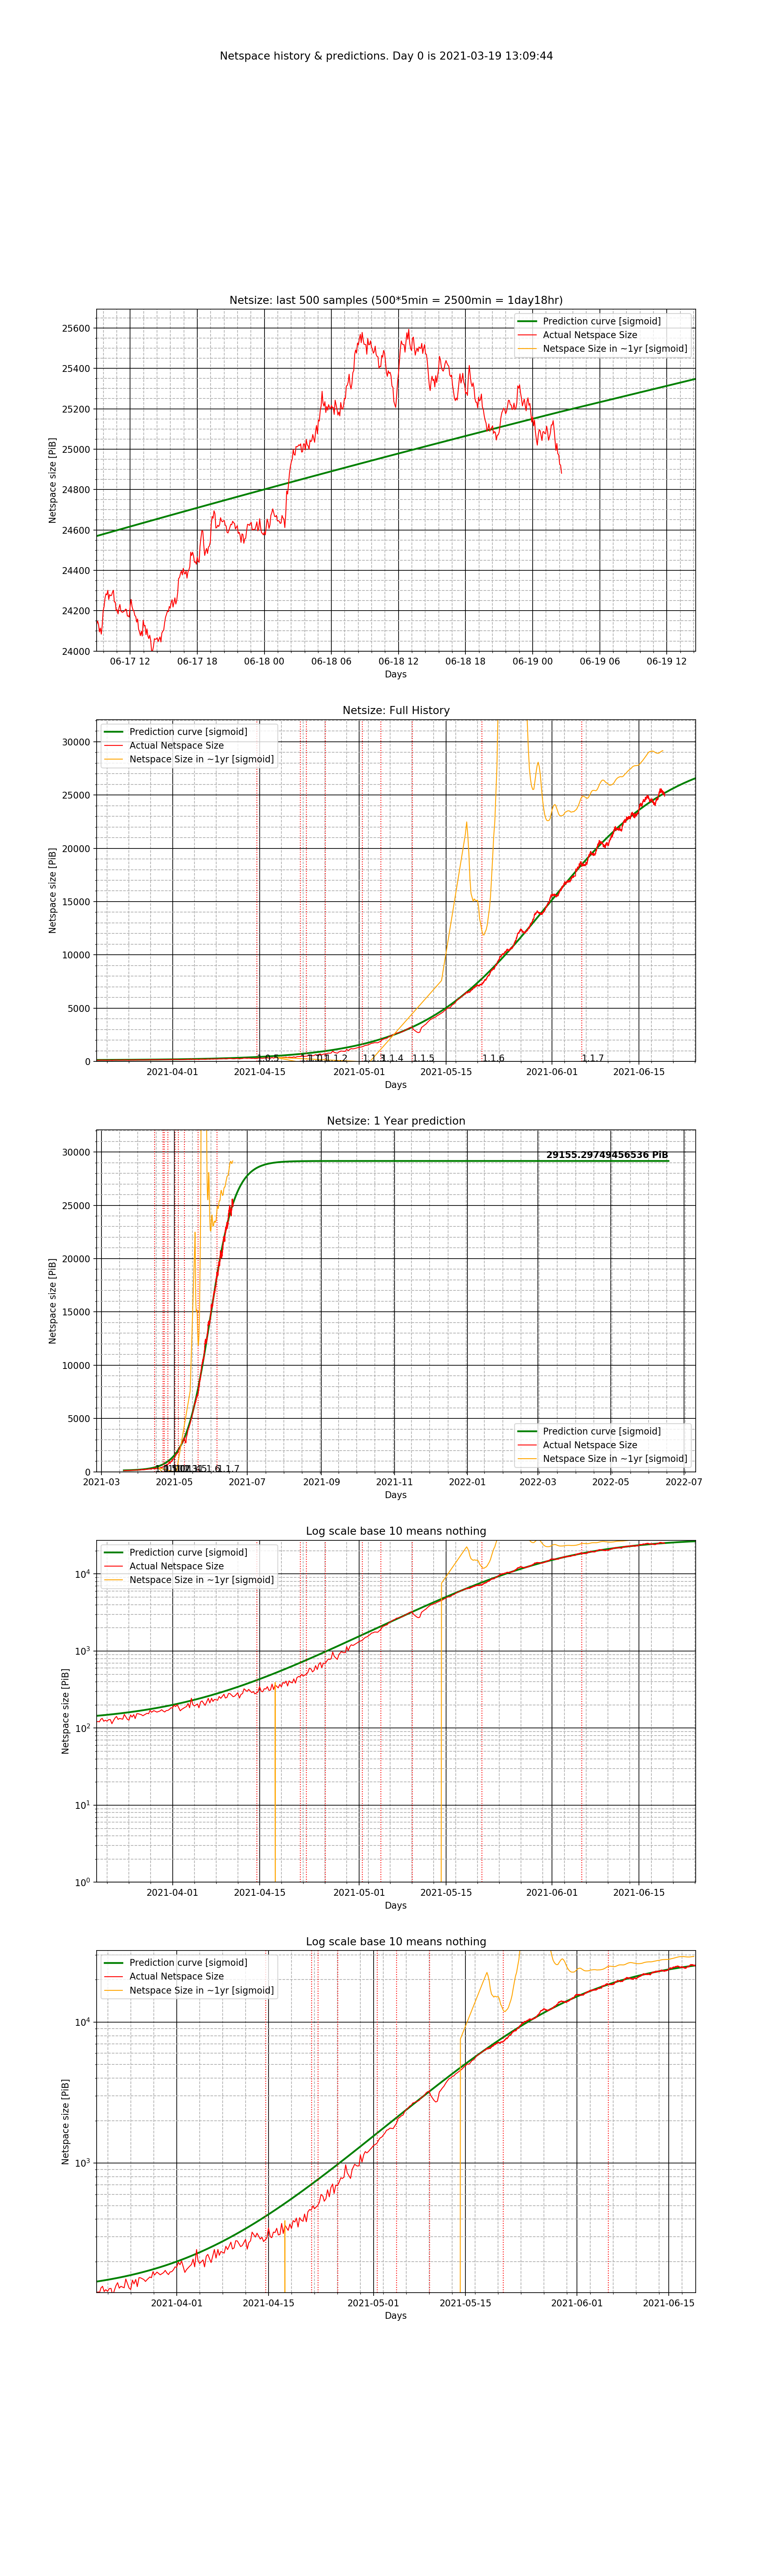

Text(0.5, 1.0, 'Log scale base 10 means nothing')

In [68]:
# Prepare the figure
fig_growth = plt.figure(num=None, figsize=(12, 40), dpi=80, facecolor='w', edgecolor='k')
ax_now  = fig_growth.add_subplot(511)
ax_zoom = fig_growth.add_subplot(512)
ax_full = fig_growth.add_subplot(513)
ax_log1 = fig_growth.add_subplot(514)
ax_log2 = fig_growth.add_subplot(515)


# Common plotting/formatting
t = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch_times[0]))
plt.suptitle("Netspace history & predictions. Day 0 is {}".format(t))

for ax in [ax_now, ax_zoom, ax_full, ax_log1, ax_log2]:
    if PLOT_EXP: 
        ax.plot(tt_future_d, yy_exp, 
                color='blue', 
                linewidth=1,
                label='Prediction curve [exponential]') 
        
    if PLOT_SIG: 
        ax.plot(tt_future_d, yy_sigmoid, 
                color='green', 
                linewidth=2,
                label='Prediction curve [sigmoid]')
    
    if PLOT_UPDATES:
        for u in updates:
            x = matplotlib.dates.date2num(u[0])
            ax.axvline(x=x, linewidth=1, color='red', linestyle=':')
            ax.text(x, 0, u[1])
            
    ax.plot(ttd, 
            net_size_PiB, 
            color='red', 
            linewidth=1,
            label='Actual Netspace Size')
    
    ax.plot(ttd_yy_preds[:-2], 
            yy_preds[:-2], 
            color='orange', 
            linewidth=1,
            linestyle='-',
            label='Netspace Size in ~1yr [sigmoid]')
    
    ax.set_xlabel("Days")
    ax.set_ylabel("Netspace size [PiB]")
    ax.grid(which='major', axis='both', linestyle='-' , color='k')
    ax.grid(which='minor', axis='both', linestyle='--')
    ax.minorticks_on()
    ax.xaxis.axis_date()
    ax.legend()

    
# Unique plotting/formatting
ax_full.text(tt_future_d[-1], yy_sigmoid[-1]*1.01, str(yy_sigmoid[-1]) + ' PiB', 
             fontweight='bold', 
             horizontalalignment='right')

now_y_lo = min(net_size_PiB[-500:-1])
now_y_hi = max(net_size_PiB[-500:-1]) + 100

ax_now.set_xlim([ttd[-500],ttd[-1]+.5])
ax_now.set_ylim([now_y_lo, now_y_hi])
ax_now.set_title("Netsize: last 500 samples (500*5min = 2500min = 1day18hr)")

ax_zoom.set_xlim([ttd[0],ttd[-1]+5])
ax_zoom.set_ylim([0,yy_preds[-2]*1.1])#net_size_PiB[-1]*1.1])
ax_zoom.set_title("Netsize: Full History")

ax_full.set_ylim([0, y_max])
ax_full.set_title("Netsize: 1 Year prediction")

ax_log1.semilogy()
ax_log1.set_xlim([ttd[0],ttd[-1]+5])
ax_log1.set_ylim([1 , net_size_PiB[-1]*1.1]) #net_size_PiB[0]
ax_log1.set_title("Log scale base 10 means nothing")

ax_log1.legend()
ax_log2.semilogy()
ax_log2.set_xlim([ttd[0], ttd[-1]])
ax_log2.set_ylim([net_size_PiB[0], y_max])
ax_log2.set_title("Log scale base 10 means nothing")




### Growth Rate

"Convolved" == "filtered"

Many things can be plotted here. What I have found useful to watch is listed in this chart. Enable plots for the others.

|                          | netsize convolved [N]  |netsize convolved [Y]| netsize sigmoid prediction |
| ---                      | :---                   | :---                | :---                       |
| derivative convolved [N] | ---                    | cyan                | green                      |
| derivative convolved [Y] | ~red~                  | blue                | ---                        |


Change kernel size for more or less smoothing. Convolution delays the response by `kernel_size` data samples on the t-axis. This is why the convolved data trails when plotted. This is _sort of halfway_ corrected here.

Here, I slide convolved plots for "clock correction". Currently, this is just the blue plot, where the netsize data was convolved. Then a derivative was taken. Then the derivative was convolved. So this is a smooth plot, that follows the cyan data, where the derivative was not "re-convolved". The cyan and blue should actually be slid to the left as well.


In [69]:
# Convolution parameters
kernel_size = int(600)
kernel = np.ones(kernel_size) / kernel_size
conv_mode = 'full'

# Create derivative dealio
net_size_PiB_dydt = np.zeros(len(net_size_PiB))
sigmoid_dydt = np.zeros(len(yy_sigmoid))


# Calculate derivative for real data
for i, y in enumerate(net_size_PiB[:-2]):
    net_size_PiB_dydt[i] = (net_size_PiB[i+1] - net_size_PiB[i]) / (ttd[i+1] - ttd[i])

# Calculate derivative for sigmoid prediction
for i, y in enumerate(yy_sigmoid[:-2]):
    sigmoid_dydt[i] = (yy_sigmoid[i+1] - yy_sigmoid[i]) / (tt_future_d[i+1] - tt_future_d[i])

    
    
# Convolve read data, then calculate derivative of it
net_size_PiB_conv = np.convolve(net_size_PiB, kernel, mode=conv_mode)
net_size_PiB_conv_dydt = np.zeros(len(net_size_PiB_conv))

for i, y in enumerate(net_size_PiB_conv[:-2-kernel_size]):
    net_size_PiB_conv_dydt[i] = (net_size_PiB_conv[i+1] - net_size_PiB_conv[i]) / (ttd[i+1] - ttd[i])


    
# Convolve the dydt of actual plot data
net_size_PiB_dydt_convolved = np.convolve(net_size_PiB_dydt, kernel, mode=conv_mode)

# Convolve the dydt of convolved actual data
net_size_PiB_conv_dydt_conv = np.convolve(net_size_PiB_conv_dydt, kernel, mode=conv_mode)



# Time arrays for plotting convolutions
n_extra_points = len(net_size_PiB_conv_dydt_conv) - len(ttd)
t_per_point = 1/24/12 # 5 minutes = 1d / 24hr / (60/5)

ttd_conv_tail = np.arange(0, n_extra_points*t_per_point, t_per_point) + ttd[-1]
ttd_conv = np.concatenate((ttd, ttd_conv_tail))
ttd_conv_shft = ttd_conv - (kernel_size/2 * t_per_point)

t_valid0_i = int(-(kernel_size/2))
t_valid0 = ttd[t_valid0_i]
t_valid1 = ttd[-1]
t_valid_conv_shift_index = int(-n_extra_points-t_valid0_i-(kernel_size/2))

print("n_extra_points: {}".format(n_extra_points))
print("t_per_point:    {}".format(t_per_point))
print()
print("len(ttd):                         {}".format(len(ttd)))
print("ttd[0]: {:.2f} \t\t  ttd[-1]: {:.2f}".format(ttd[0], ttd[-1]))
print()
print("len(tt_future_d):                 {}".format(len(tt_future_d)))
print("tt_future_d[0]: {:.2f} \t  tt_future_d[-1]: {:.2f}".format(tt_future_d[0], tt_future_d[-1]))
print()
print("len(ttd_conv_tail)                {}".format(len(ttd_conv_tail)))
print("ttd_conv_tail[0]: {:.2f} \t  ttd_conv_tail[-1]: {:.2f}".format(ttd_conv_tail[0], ttd_conv_tail[-1]))
print()
print("len(ttd_conv):                    {}".format(len(ttd_conv)))
print("ttd_conv[0]: {:.2f} \t\t  ttd_conv[-1]: {:.2f}".format(ttd_conv[0], ttd_conv[-1]))
print()
print("len(ttd_conv_shft):               {}".format(len(ttd_conv_shft)))
print("ttd_conv_shft[0]: {:.2f} \t  ttd_conv_shft[-1]: {:.2f}".format(ttd_conv_shft[0], ttd_conv_shft[-1]))
print()

print("len(net_size_PiB_dydt_convolved): {}".format(len(net_size_PiB_dydt_convolved)))
print("len(net_size_PiB_conv_dydt_conv): {}".format(len(net_size_PiB_conv_dydt_conv)))


#print("net_size_PiB[0:4]: {}".format(net_size_PiB[0:4]))
#print("net_size_PiB_dydt[0:4]: {}".format(net_size_PiB_dydt[0:4]))
#print("yy_sigmoid[50:64]: {}".format(yy_sigmoid[50:64]))
#print("sigmoid_dydt[50:64]: {}".format(sigmoid_dydt[50:64]))



n_extra_points: 1198
t_per_point:    0.003472222222222222

len(ttd):                         9383
ttd[0]: 737868.80 		  ttd[-1]: 737960.11

len(tt_future_d):                 9748
tt_future_d[0]: 737868.80 	  tt_future_d[-1]: 738324.11

len(ttd_conv_tail)                1198
ttd_conv_tail[0]: 737960.11 	  ttd_conv_tail[-1]: 737964.26

len(ttd_conv):                    10581
ttd_conv[0]: 737868.80 		  ttd_conv[-1]: 737964.26

len(ttd_conv_shft):               10581
ttd_conv_shft[0]: 737867.76 	  ttd_conv_shft[-1]: 737963.22

len(net_size_PiB_dydt_convolved): 9982
len(net_size_PiB_conv_dydt_conv): 10581


/Users/ethanblagg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


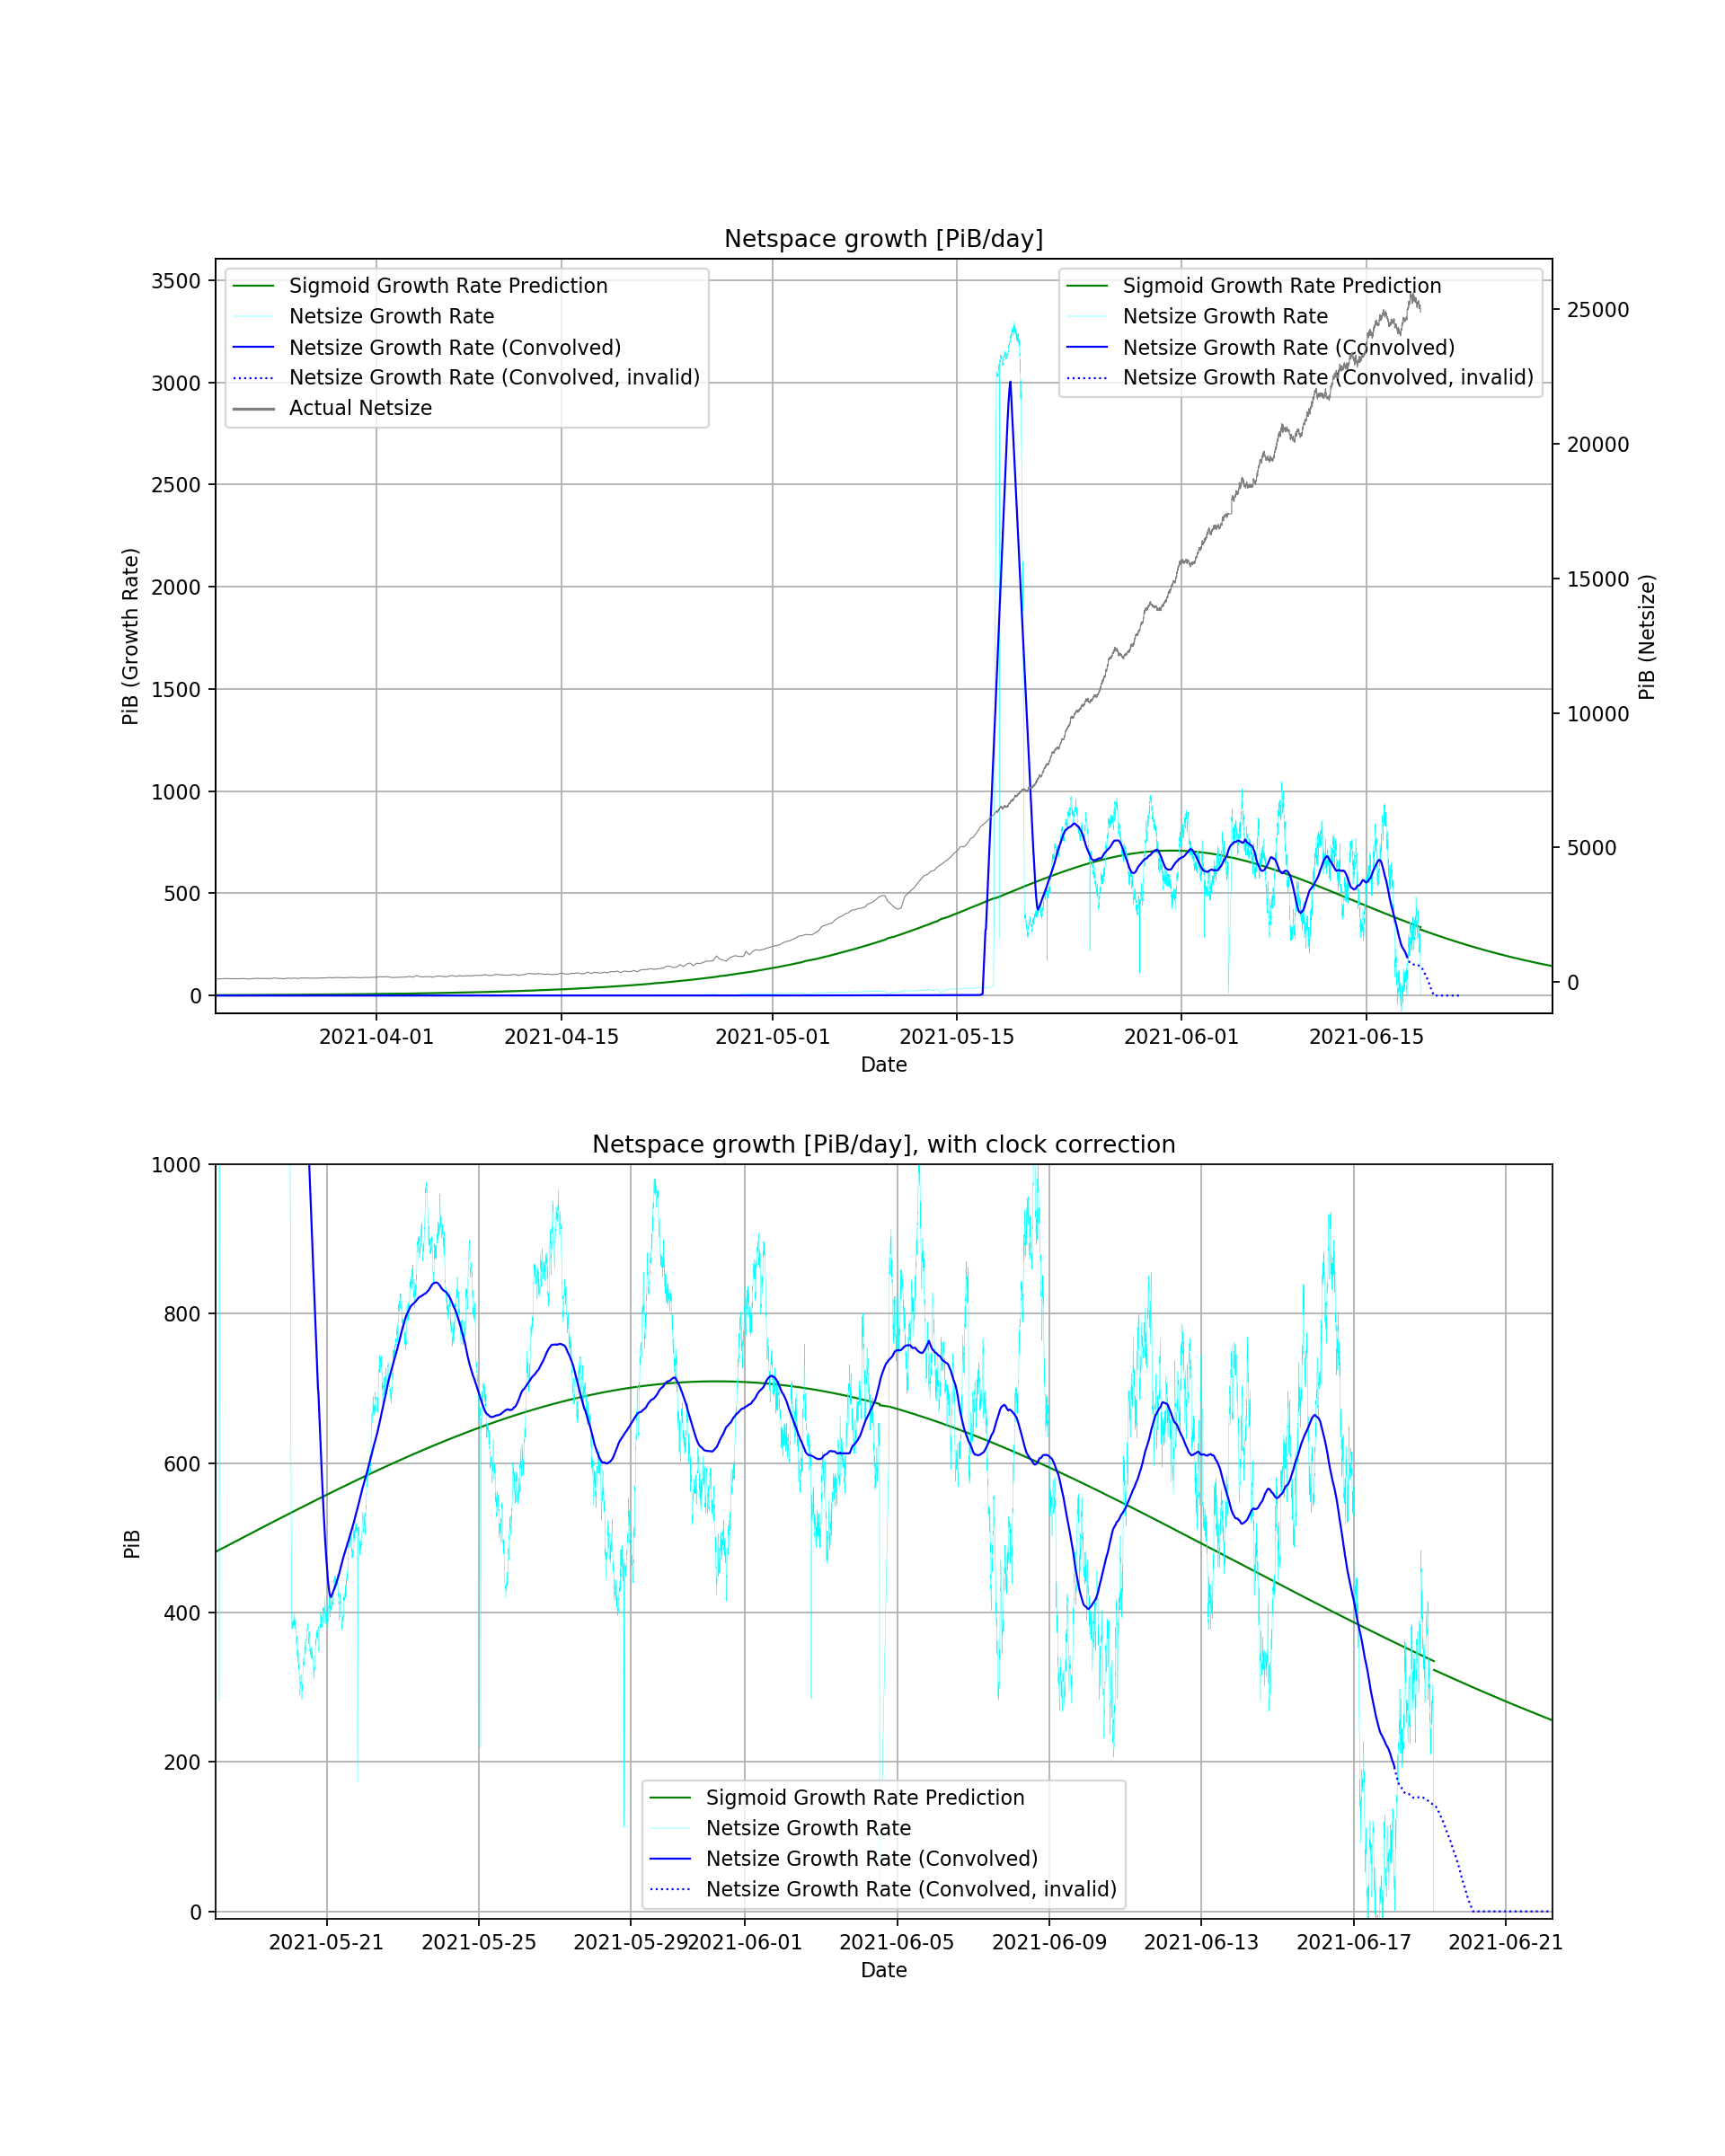

In [70]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Create the figure and subplot
fig_growth_dydt = plt.figure(num=None, figsize=(12, 15), dpi=80, facecolor='w', edgecolor='k')
ax_dydt = fig_growth_dydt.add_subplot(211)
ax_shft = fig_growth_dydt.add_subplot(212)
ax_netsize = ax_dydt.twinx()


# Plotting
for ax in [ax_dydt, ax_shft]:
    
    #ax.plot(ttd[:],
    #        net_size_PiB[0:len(ttd)],
    #        color='magenta',
    #        linewidth=1,
    #        label="Actual Netsize (Convolved)")
    
    ax.plot(tt_future_d, sigmoid_dydt,
            color='green',
            linewidth=1, 
            label="Sigmoid Growth Rate Prediction")

    ax.plot(ttd[:],
            net_size_PiB_conv_dydt[0:len(ttd)],
            color='cyan',
            linewidth=.2, 
            label="Netsize Growth Rate")
    
    ax.plot(ttd_conv_shft[:t_valid_conv_shift_index],
            net_size_PiB_conv_dydt_conv[:t_valid_conv_shift_index], 
            color='blue',  
            linewidth=1,
            label="Netsize Growth Rate (Convolved)")
    
    ax.plot(ttd_conv_shft[t_valid_conv_shift_index:],
            net_size_PiB_conv_dydt_conv[t_valid_conv_shift_index:], 
            color='blue',  
            linewidth=1,
            linestyle=':',
            label="Netsize Growth Rate (Convolved, invalid)")
    
    # Common formatting
    ax.xaxis.axis_date()
    ax.grid()
    ax.set_xlabel("Date")
    ax.set_ylabel("PiB")


    
ax_netsize.plot(ttd[:],
                net_size_PiB[0:len(ttd)],
                color='grey',
                linewidth=.5,
                label="Actual Netsize (Convolved)")
    
# Unique formatting
ax_dydt.set_title("Netspace growth [PiB/day]")
ax_dydt.set_ylim([min(net_size_PiB_conv_dydt[600:])*1.1, max(net_size_PiB_conv_dydt[600:])*1.1])
ax_dydt.set_xlim([ttd[0], ttd[-1]+10])
ax_dydt.legend()
ax_dydt.set_ylabel("PiB (Growth Rate)")
ax_netsize.set_ylabel("PiB (Netsize)")

ax_shft.set_title("Netspace growth [PiB/day], with clock correction")
ax_shft.set_xlim([ttd[250], ttd_conv_shft[-1]])
ax_shft.set_ylim([-10, 1000])
ax_shft.legend()






# Update the legend for both axes in subplot 1
handles, labels = ax_shft.get_legend_handles_labels()
patch = Line2D([0], [0], label = 'Actual Netsize',color='grey')
handles.append(patch)
plt.legend(handles=handles)

### Insert: Acceleration of growth

In [71]:
sigmoid_accel = np.zeros(len(yy_sigmoid))
netsize_accel = np.zeros(len(net_size_PiB_conv_dydt_conv))


# Calc d2y/dt2 for sigmoid
for i, y in enumerate(sigmoid_dydt[:-2]):
    sigmoid_accel[i] = (sigmoid_dydt[i+1] - sigmoid_dydt[i]) / (tt_future_d[i+1] - tt_future_d[i])


for i, y in enumerate(net_size_PiB_conv_dydt_conv[:-2]):
    netsize_accel[i] = (net_size_PiB_conv_dydt_conv[i+1] - net_size_PiB_conv_dydt_conv[i]) / \
                       (ttd_conv[i+1] - ttd_conv[i])

# filter for invalid values, then convolve
netsize_accel[netsize_accel < -10000] = 0
netsize_accel_conv = np.convolve(netsize_accel, kernel, mode=conv_mode)
    
# Time arrays for plotting convolutions
n_extra_points = len(netsize_accel_conv) - len(ttd)
t_per_point = 1/24/12 # 5 minutes = 1d / 24hr / (60/5)

ttd_conv_tail2 = np.arange(0, n_extra_points*t_per_point, t_per_point) + ttd[-1]
ttd_conv2 = np.concatenate((ttd, ttd_conv_tail2))
ttd_conv_shft2 = ttd_conv2 - (kernel_size/2 * t_per_point)

t_valid0_i = int(-(kernel_size/2))
t_valid_conv_shift_index = int(-n_extra_points-t_valid0_i-(kernel_size/2))

print("len(ttd): {}".format(len(ttd)))
print("len(sigmoid_dydt):    {}".format(len(sigmoid_dydt)))
print("len(sigmoid_accel):   {}".format(len(sigmoid_accel)))
print("len(netsize_accel):   {}".format(len(netsize_accel)))
print("len(net_size_PiB_conv_dydt_conv): {}".format(len(net_size_PiB_conv_dydt_conv)))
print("len(netsize_accel_conv): {}".format(len(netsize_accel_conv)))
print("len(ttd_conv_shft2): {}".format(len(ttd_conv_shft2)))

print("t_valid_conv_shift_index: {}".format(t_valid_conv_shift_index))
print()
print("ttd_conv_shft2[t_valid_conv_shift_index-5:t_valid_conv_shift_index+5]: \n\t{}".format(ttd_conv_shft2[t_valid_conv_shift_index-5:t_valid_conv_shift_index+5]))
print()
print("netsize_accel_conv[t_valid_conv_shift_index-5:t_valid_conv_shift_index+5]: \n\t{}".format(netsize_accel_conv[t_valid_conv_shift_index-5:t_valid_conv_shift_index+5]))
print()
print("netsize_accel_conv[t_valid_conv_shift_index-5+kernel_size:t_valid_conv_shift_index+5+kernel_size]: \n\t{}".format(netsize_accel_conv[t_valid_conv_shift_index-5+kernel_size:t_valid_conv_shift_index+5+kernel_size]))
print()
print("netsize_accel[t_valid_conv_shift_index-5+kernel_size:t_valid_conv_shift_index+5+kernel_size]: \n\t{}".format(netsize_accel[t_valid_conv_shift_index-5+kernel_size:t_valid_conv_shift_index+5+kernel_size]))
# ttd_conv_shft2[:t_valid_conv_shift_index]
# netsize_accel_conv[:t_valid_conv_shift_index]
#netsize_accel

print(netsize_accel[(netsize_accel < -10000)])
print(netsize_accel_conv[(netsize_accel_conv < -10000)])
print(netsize_accel_conv[(netsize_accel_conv > 10000)])

print(type(ttd_conv_shft))
print(type(ttd_conv_shft[0]))
for i, a in enumerate(ttd_conv_shft2[:-2]):
    #if ttd_conv_shft2[i+1] - ttd_conv_shft2[i] > 0.03:
    #    print(i)
    if not isinstance(a, np.float64):
        print(i)


len(ttd): 9383
len(sigmoid_dydt):    9748
len(sigmoid_accel):   9748
len(netsize_accel):   10581
len(net_size_PiB_conv_dydt_conv): 10581
len(netsize_accel_conv): 11180
len(ttd_conv_shft2): 11180
t_valid_conv_shift_index: -1797

ttd_conv_shft2[t_valid_conv_shift_index-5:t_valid_conv_shift_index+5]: 
	[737959.05209491 737959.05556713 737959.05903935 737959.06251157
 737959.0659838  737959.0659838  737959.06945602 737959.07292824
 737959.07640046 737959.07987269]

netsize_accel_conv[t_valid_conv_shift_index-5:t_valid_conv_shift_index+5]: 
	[-224.95723607 -225.38383856 -225.75363207 -226.07153837 -225.99817633
 -226.29878614 -226.58236359 -226.85055419 -227.1287979  -227.3479183 ]

netsize_accel_conv[t_valid_conv_shift_index-5+kernel_size:t_valid_conv_shift_index+5+kernel_size]: 
	[-93.62768433 -93.21509362 -92.83120959 -92.46297203 -92.46297203
 -92.10887794 -91.75999167 -91.42012517 -91.07170393 -90.73848216]

netsize_accel[t_valid_conv_shift_index-5+kernel_size:t_valid_conv_shift_index+

/Users/ethanblagg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


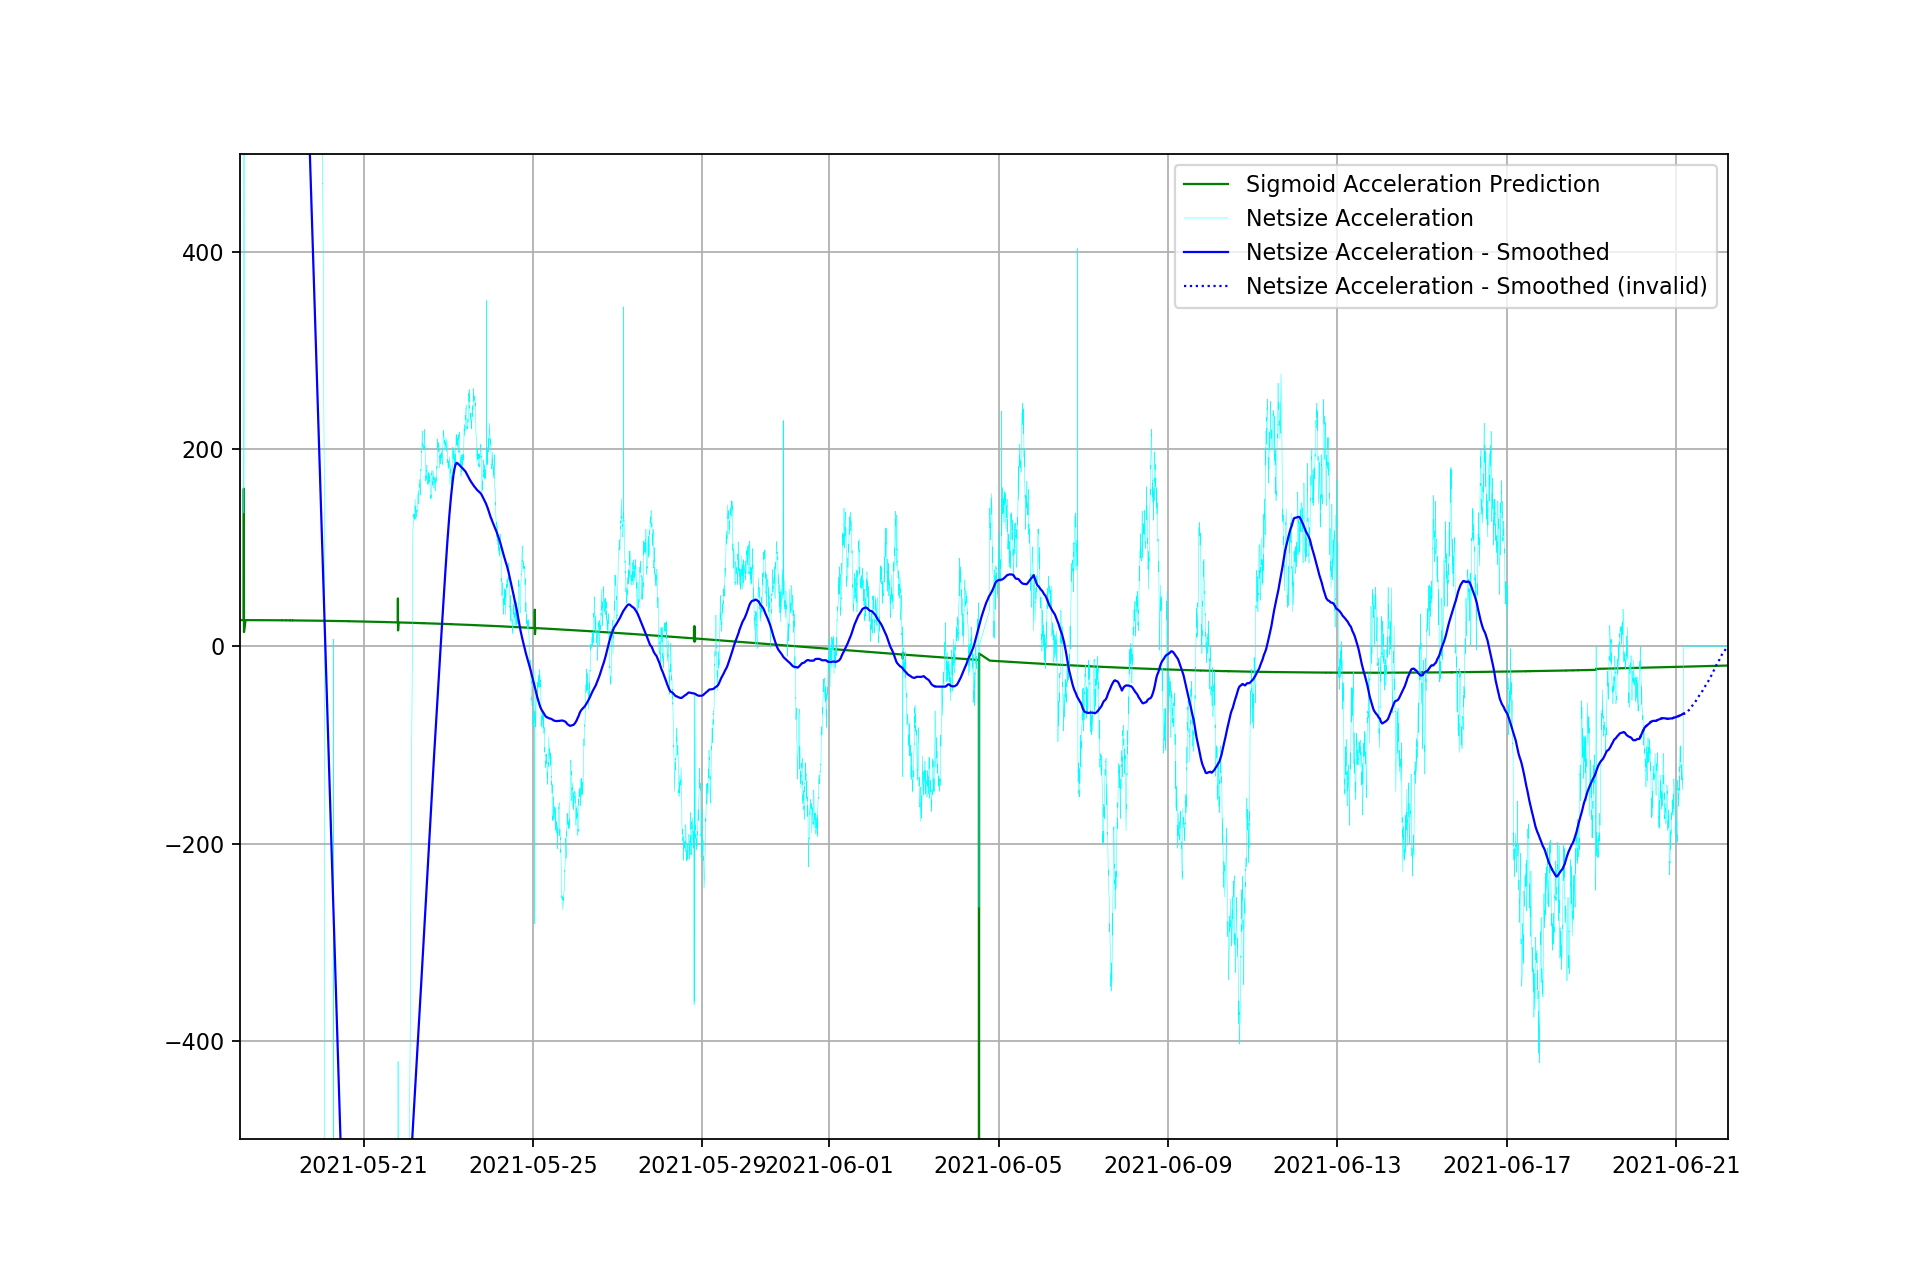

In [81]:
# Create the figure and subplot
fig_growth_accel = plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
ax_accel = fig_growth_accel.add_subplot(111)



# Plot
ax_accel.plot(tt_future_d, 
              sigmoid_accel,
              color='green',
              linewidth=1, 
              label="Sigmoid Acceleration Prediction")

ax_accel.plot(ttd_conv[0:len(netsize_accel)], 
              netsize_accel,
              color='cyan',
              linewidth=.2,
              label="Netsize Acceleration")

ax_accel.plot(ttd_conv_shft2[0:int(t_valid_conv_shift_index/2)], 
              netsize_accel_conv[0:int(t_valid_conv_shift_index/2)],
              color='blue',
              linewidth=1,
              label="Netsize Acceleration - Smoothed")

ax_accel.plot(ttd_conv_shft2[t_valid_conv_shift_index+kernel_size:], 
              netsize_accel_conv[t_valid_conv_shift_index+kernel_size:],
              color='blue',
              linestyle=':',
              linewidth=1,
              label="Netsize Acceleration - Smoothed (invalid)")

#ax_accel.plot(ttd_conv_shft2, 
#              netsize_accel_conv,
#              color='purple',
#              linewidth=1,
#              label="ns")

# Formatting
ax_accel.xaxis.axis_date()
ax_accel.grid()
ax_accel.set_xlim([ttd[250], ttd_conv_shft[-1]])
ax_accel.set_ylim([-500, 500])
ax_accel.legend()


### PMF - Create a matrix with win percentages from binomial pmf blah blah stats bullshit

Change 'r' variable to see probabilities for winning r times
e.g. to see a distribution for likelihood of winning 6 times, set r = 6

In [16]:
import pandas as pd
from scipy.stats import binom

# n = number of trials
# p = probability of winning
# r = # of wins 

pmf_dist_days = 365
challenges_per_day = 4608
num_data_points= len(ttd)
r = 1
win_percents = np.zeros((num_data_points, pmf_dist_days))
challenges_range = np.arange(challenges_per_day, pmf_dist_days*challenges_per_day, challenges_per_day)

for i in range(0, num_data_points):
    p = win_prob[i]
    
    for j, n in enumerate(challenges_range):
        win_percents[i][j] = binom.pmf(r, n, p)


KeyboardInterrupt: 

### Plot PMFs across real time

In [ ]:
%matplotlib notebook    
# % indicates magic function -> runs command. Run %magic in a cell for more info

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from colour import Color

print("num_data_points: {}".format(num_data_points))
print("days: {}".format(pmf_dist_days))

# Get range of max probabilty of win indices, then set color range up to that value
max_day_index = 0
for sample in range(0, num_data_points):    
    m = win_percents[sample].argmax()
    if (m > max_day_index):
        max_day_index = m
    
print("max_day_index: {}".format(max_day_index))

green = Color("green")
colors_year = list(green.range_to(Color("red"), max_day_index+1))


fig_pmf = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
ax_pmf = fig_pmf.add_subplot(111, projection='3d')

x_array = np.ones(pmf_dist_days)
max_prob_indices = np.zeros(num_data_points)

print(win_percents.shape)

line_width = 100/len(ttd) #0.1
print("line_width: {}".format(line_width))

print("ttd[0]: {}".format(ttd[0]))

for sample in range(0, num_data_points):    
    max_prob_indices[sample] = win_percents[sample].argmax()
    
    ax_pmf.plot(ttd[sample]*x_array, np.arange(0, pmf_dist_days), win_percents[sample][:],
                color=colors_year[int(max_prob_indices[sample])].hex_l,
                linewidth= line_width
               )
    ax_pmf.plot([ttd[sample]], max_prob_indices[sample], 0,
                marker='o',
                markersize=2,
                color=colors_year[int(max_prob_indices[sample])].hex_l
    )
    
elev = 19 #12       
angle = -1 #-12
ax_pmf.view_init(elev, angle)   
ax_pmf.set_title("")
ax_pmf.set_ylabel("Days til win")
ax_pmf.set_xlabel("Plotting Date\n\n\n")
ax_pmf.set_zlabel("Chance of win")
ax_pmf.xaxis.axis_date()
ax_pmf.grid(which='major', axis='y', linestyle='-')
ax_pmf.grid(which='minor', axis='y', linestyle='--', bottom='off')
#ax_pmf.yaxis.minorticks_on()

#ax_pmf.set_xlim([58, ttd[-1]])
ax_pmf.set_xlim([ttd[first_sample_index], ttd[-1]])

### Insert: PMF plot with meshgrid style

In [ ]:
print("coming soon!")

### Plot fraction of owned netspace

<IPython.core.display.Javascript object>


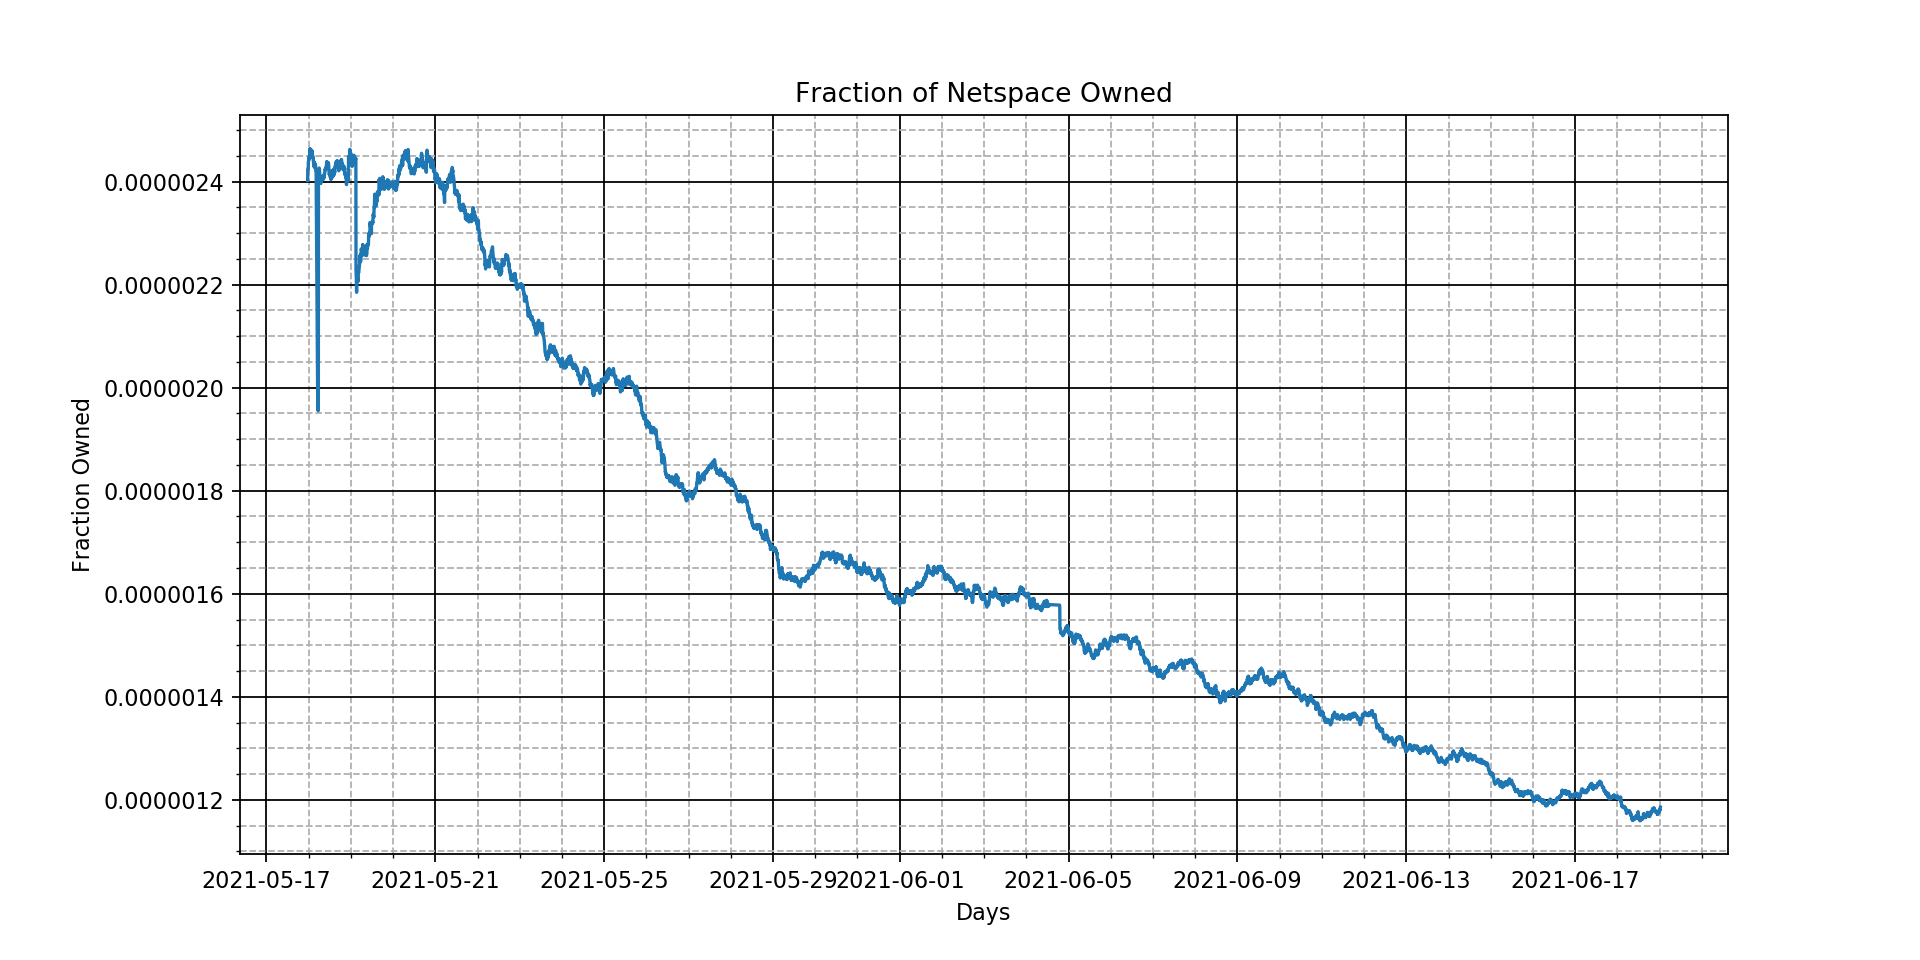

In [17]:
netfrac_fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
netfrac_ax = netfrac_fig.add_subplot(111)

#netfrac_ax.plot(xx[219:], win_prob[219:])


netfrac_ax.plot(ttd[219:], win_prob[219:])
netfrac_ax.xaxis.axis_date()

netfrac_ax.set_title("Fraction of Netspace Owned")
netfrac_ax.set_xlabel("Days")
netfrac_ax.set_ylabel("Fraction Owned")

plt.grid(which='major', axis='both', linestyle='-' , color='k')
plt.grid(which='minor', axis='both', linestyle='--')
plt.minorticks_on()

#netfrac_ax.set_xlim([58, xx[-1]])

#for i,n in enumerate(xx):
#    if xx[i+1] < xx[i]:
#        print(i+1)